In [47]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
# torhc dataset
from torch.utils.data import Dataset, DataLoader

# train test split
from sklearn.model_selection import train_test_split

from torch.optim.lr_scheduler import ReduceLROnPlateau

import pandas as pd
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

#import summary for models
from torchsummary import summary

import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

import matplotlib.pyplot as plt

In [48]:
all_data = pd.read_csv("../Data/Train_and_Validate_EEG.csv", index_col=0).drop("Unnamed: 122",axis=1)
data = all_data.drop(['sex','eeg.date','education','specific.disorder'], axis=1).dropna(axis=0)

# Encode disorders
encoder = OrdinalEncoder()
data[['main.disorder']] = encoder.fit_transform(data[['main.disorder']])

X = data.drop(['main.disorder'], axis=1).dropna(axis=0)
y = data['main.disorder']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
bands = ['gamma', 'highbeta', 'beta', 'alpha', 'theta', 'delta']
bands2 = ['F.gamma', 'E.highbeta', 'D.beta', 'C.alpha', 'B.theta', 'A.delta']

# Separate column names based on whether they are PSD or coherence
AB_per_band = {}
AB_cols = []
COH_per_band = {}
COH_cols = []

for band in bands:
    AB_per_band[band] = []
    COH_per_band[band] = []

for col_name in X_train.drop(['age','IQ'], axis=1).columns:
    col_split = col_name.split('.')
    if col_split[0] == 'AB':
        AB_per_band[col_split[2]].append(col_name)
        AB_cols.append(col_name)
    else:
        COH_per_band[col_split[2]].append(col_name)
        COH_cols.append(col_name)

In [50]:
# Get all electrode names
electrodes = set()
for col in COH_cols:
    col_split = col.split('.')
    # elec1 = col_split[4]
    electrodes.add(col_split[3]+'.'+col_split[4])
    # elec2 = col_split[6]
    electrodes.add(col_split[5]+'.'+col_split[6])

electrodes = list(electrodes)
len(electrodes)

19

## data preprocessing
coherence data shape = [num individuals, frequency bands, electrodes, electrodes]
PSD data shape = [num individuals, frequency bands, electrodes]

In [51]:
num_samples = X_train.shape[0]
num_nodes = len(electrodes)
num_bands = len(bands)

In [52]:
def getCoherenceStacked(coherence):
    adj_tensors = []

    # for each individual
    for i in range(coherence.shape[0]):
        indiv_tensors = []

        # for each band
        for band_idx in range(len(bands2)):
            # adjacency matrix electrodes x electrodes
            adj_matrix = np.zeros([len(electrodes),len(electrodes)])

            for elec1 in range(len(electrodes)):
                for elec2 in range(elec1+1, len(electrodes)):
                    col_name = 'COH.'+bands2[band_idx]+'.'+electrodes[elec1]+'.'+electrodes[elec2]
                    if col_name in coherence.columns:
                        adj_matrix[elec1][elec2] = coherence.iloc[i,:][col_name] #individual's row, then get value
                    else: 
                        col_name = 'COH.'+bands2[band_idx]+'.'+electrodes[elec2]+'.'+electrodes[elec1]
                        adj_matrix[elec1][elec2] = coherence.iloc[i,:][col_name] #individual's row, then get value
            indiv_tensors.append(torch.from_numpy(adj_matrix).fill_diagonal_(1.0))

        adj_tensors.append(torch.stack(indiv_tensors))
    
    adj_matrices = torch.stack(adj_tensors)
    # print(adj_matrices.shape)
    adj_matrices = (adj_matrices + adj_matrices.transpose(2, 3)) / 2  # Ensure symmetry
    print(adj_matrices.shape)
    return adj_matrices

In [53]:
def getPSDStacked(psd):
    psd_tensors = []
    # for each individual
    for i in range(psd.shape[0]):
        psd_mat = np.zeros([len(electrodes),len(bands2)])

        # for each band
        for band_idx in range(len(bands2)):
            for elec1 in range(len(electrodes)):
                col_name = 'AB.'+bands2[band_idx]+'.'+electrodes[elec1]
                psd_mat[elec1][band_idx] = psd.iloc[i,:][col_name] #individual's row, then get value
            
        psd_tensors.append(torch.from_numpy(psd_mat))

    node_features = torch.stack(psd_tensors)
    print(node_features.shape)
    return node_features

In [54]:
adj_matrices = getCoherenceStacked(X_train)
adj_matrices_val = getCoherenceStacked(X_val)

torch.Size([672, 6, 19, 19])
torch.Size([168, 6, 19, 19])


In [55]:
node_features = getPSDStacked(X_train)
node_features_val = getPSDStacked(X_val)

torch.Size([672, 19, 6])
torch.Size([168, 19, 6])


In [56]:
# create data loaders from adj_matrices and node_features
class EEGDataset(Dataset):
    def __init__(self, adj_matrices, node_features, labels):
        self.adj_matrices = torch.tensor(adj_matrices, dtype=torch.float32)
        self.node_features = torch.tensor(node_features, dtype=torch.float32)
        self.labels = torch.tensor(labels.to_list(), dtype=torch.long)
        if len(self.adj_matrices) != len(self.labels):
            raise ValueError("Adjacency matrices and labels must have the same length: {} != {}".format(len(self.adj_matrices), len(self.labels)))
        if len(self.node_features) != len(self.labels):
            raise ValueError("Node features and labels must have the same length: {} != {}".format(len(self.node_features), len(self.labels)))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.node_features[idx], self.labels[idx]

print(adj_matrices.shape)
train_dataset = EEGDataset(adj_matrices, node_features, y_train)
val_dataset = EEGDataset(adj_matrices_val, node_features_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

torch.Size([672, 6, 19, 19])


/var/folders/pz/bsrlw1051zq7wv21r5cq1y280000gn/T/ipykernel_53715/4005209015.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.adj_matrices = torch.tensor(adj_matrices, dtype=torch.float32)
/var/folders/pz/bsrlw1051zq7wv21r5cq1y280000gn/T/ipykernel_53715/4005209015.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.node_features = torch.tensor(node_features, dtype=torch.float32)


## modeling

### graph construction

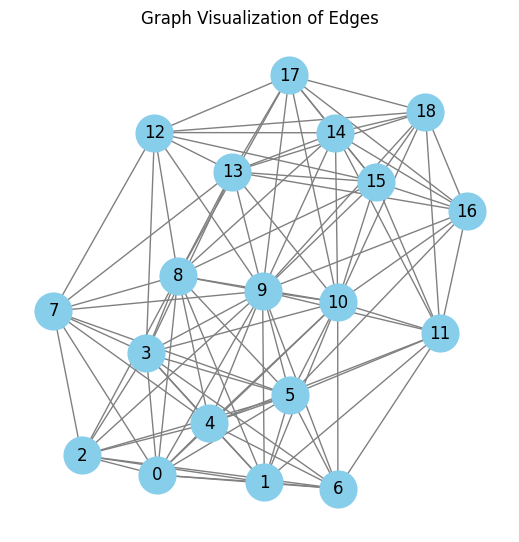

In [57]:
import networkx as nx

EDGES_PER_NODE = 10

real_data = pd.read_csv("../Data/Train_and_Validate_EEG.csv")
only_coh_cols = [col for col in real_data.columns if "COH" in col]
psd = real_data[only_coh_cols]

band_coh = [np.zeros((19, 19)) for _ in range(6)]
for col in psd.columns:
    loc1, loc2 = col.split(".")[3], col.split(".")[5]
    band = ord(col.split(".")[1]) - ord('A')
    band_coh[band][ord(loc1)-97,ord(loc2)-97] += psd[col].mean()
    band_coh[band][ord(loc2)-97,ord(loc1)-97] += psd[col].mean()

band_coh = np.array(band_coh)
band_coh_max = np.max(band_coh, axis=0)

# Find the indices of the top 10 values in band_coh_max, a 2D numpy array of shape (19, 19)

np.array(np.unravel_index(np.argsort(band_coh_max, axis=None), band_coh_max.shape)).transpose()[-1:-4:-1]
# np.array(np.unravel_index(np.argsort(band_coh_max, axis=None), band_coh_max.shape)).transpose()[-50:]

edges = []
for i in range(19):
    edges.append(np.array(np.argsort(band_coh_max[i], axis=None)).transpose()[-1:-1 * EDGES_PER_NODE:-1])
edges = np.array(edges)
edges

edge_pairs = []

# Make a graph visualization of these edges
G = nx.Graph()

# Add nodes
for i in range(19):
    G.add_node(i)

# Add edges
for i, edge_list in enumerate(edges):
    for j in edge_list:
        G.add_edge(i, j)
        if i < j:
            edge_pairs.append((i,j))

# Draw the graph
plt.figure(figsize=(5,5))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=700, edge_color='gray')
plt.title("Graph Visualization of Edges")
plt.show()

In [80]:
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

edge_index = torch.tensor(edge_pairs).transpose(0,1)
# make edge_index with dims [2,29] into shape [2,29,6] by copying

edge_attr = torch.tensor([band_coh_max[edge] / np.max(band_coh_max) for edge in edge_pairs], dtype=torch.float32)
data = Data(x=train_dataset.node_features, edge_index=edge_index, edge_attr=edge_attr)

# Define GNN Model
class GCN(torch.nn.Module):
    def __init__(self, in_channels=6, hidden_channels=16, out_channels=128):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels * 4)
        self.conv3 = GCNConv(hidden_channels * 4, out_channels)
        
        # convert batch_size x 19 x out_channels to batch_size x out_channels by making 19 layers connect to one of the 64
        self.fc1 = nn.Linear(out_channels * 19, out_channels * 19 // 8)
        self.fc2 = nn.Linear(out_channels * 19 // 8, hidden_channels * 2)
        self.fc3 = nn.Linear(hidden_channels * 2, 7)
        
        self.bn1 = nn.BatchNorm1d(out_channels * 19 // 8)
        self.bn2 = nn.BatchNorm1d(hidden_channels * 2)
        
        self.dropout = nn.Dropout(p=0.06)

    def forward(self, x, edge_index, edge_attr):
        # Apply GCNConv layers
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc1(torch.flatten(x, start_dim=1))
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

# The number of input channels should match the number of features in node_features
in_channels = node_features.shape[2]
model = GCN(in_channels=in_channels)

out = model(data.x[:3], data.edge_index, data.edge_attr)
print(data.x[:3].shape)
print(data.edge_attr.shape)
print(data.edge_index.shape)
out.shape

torch.Size([3, 19, 6])
torch.Size([78])
torch.Size([2, 78])


torch.Size([3, 7])

In [73]:
# Print the model
print(model)
# how many parameters?
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

GCN(
  (conv1): GCNConv(6, 16)
  (conv2): GCNConv(16, 64)
  (conv3): GCNConv(64, 128)
  (fc1): Linear(in_features=2432, out_features=304, bias=True)
  (fc2): Linear(in_features=304, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=7, bias=True)
  (bn1): BatchNorm1d(304, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.06, inplace=False)
)
759815


In [74]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(),
                       lr=0.00004,
                       weight_decay=1e-5)

scheduler = ReduceLROnPlateau(optimizer,
                              mode='min',
                              factor = 0.1,
                              patience = 3,
                              min_lr = 1e-5,
                              verbose = True)

/Users/hamsterlord/.pyenv/versions/3.10.4/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [75]:
print(len(train_dataset))
print(len(train_loader))

672
21


In [76]:
best_loss = np.inf
patience = 20
min_delta = 0.01
early_stop_counter = 0

train_losses = []
train_accs = []
val_losses = []
val_accs = []
final_epoch = 0

num_epochs = 300

for epoch in range(num_epochs):

    # train
    model.train()
    running_loss = 0.
    running_accuracy = 0.

    for data in train_loader:
        inputs, labels = data

        optimizer.zero_grad()  # zero gradients

        outputs = model.forward(inputs, edge_index, edge_attr)  # input net

        labels = labels.long()

        loss = criterion(outputs, labels)
        loss.backward()

        outputs = F.softmax(outputs, dim=1)
        top_p, top_class = outputs.topk(k=1, dim=1)

        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == labels).float().sum()
        running_accuracy += accuracy.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = running_accuracy / len(train_dataset)
    train_accs.append(epoch_accuracy)

    if epoch % 5 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Acc: {epoch_accuracy:.4f}")
    train_losses.append(epoch_loss)

    # val
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    correct = total = 0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data

            outputs = model(inputs, edge_index, edge_attr)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)

            accuracy = (predicted == labels).float().mean()
            val_accuracy += accuracy.item()

    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader)

    if epoch % 5 == 0:
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}\n")
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)


    # Early stopping
    if val_loss < best_loss - min_delta:
        best_loss = val_loss
        early_stop_counter = 0
        #best_model_state = model.state_dict()
    else:
        early_stop_counter += 1

    # if early_stop_counter >= patience:
    #     print(f"Early stopping at epoch {epoch+1}.")
    #     final_epoch = epoch+1
    #     #model.load_state_dict(best_model_state)
    #     break

    scheduler.step(val_loss)

Epoch [1/300], Loss: 2.0367, Acc: 0.0923
Validation Loss: 1.9888, Validation Accuracy: 0.0885

Epoch [6/300], Loss: 1.9454, Acc: 0.1488
Validation Loss: 2.0029, Validation Accuracy: 0.0833

Epoch [11/300], Loss: 1.9471, Acc: 0.1637
Validation Loss: 1.9940, Validation Accuracy: 0.1042

Epoch [16/300], Loss: 1.9371, Acc: 0.1741
Validation Loss: 1.9877, Validation Accuracy: 0.1146

Epoch [21/300], Loss: 1.9256, Acc: 0.1801
Validation Loss: 2.0047, Validation Accuracy: 0.0885

Epoch [26/300], Loss: 1.9142, Acc: 0.1994
Validation Loss: 1.9899, Validation Accuracy: 0.0885

Epoch [31/300], Loss: 1.9017, Acc: 0.2336
Validation Loss: 1.9822, Validation Accuracy: 0.1302

Epoch [36/300], Loss: 1.9057, Acc: 0.2262
Validation Loss: 1.9779, Validation Accuracy: 0.1250

Epoch [41/300], Loss: 1.8981, Acc: 0.2202
Validation Loss: 1.9687, Validation Accuracy: 0.1354

Epoch [46/300], Loss: 1.8838, Acc: 0.2336
Validation Loss: 1.9722, Validation Accuracy: 0.1406

Epoch [51/300], Loss: 1.8726, Acc: 0.2574


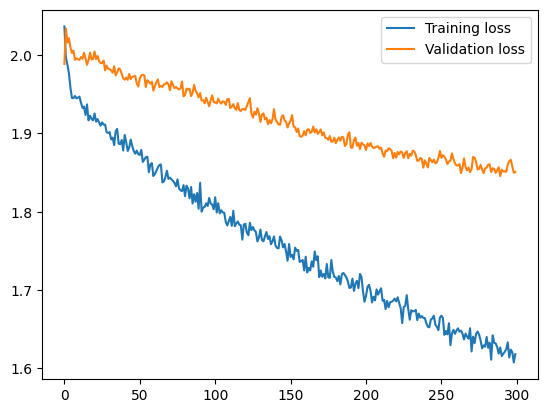

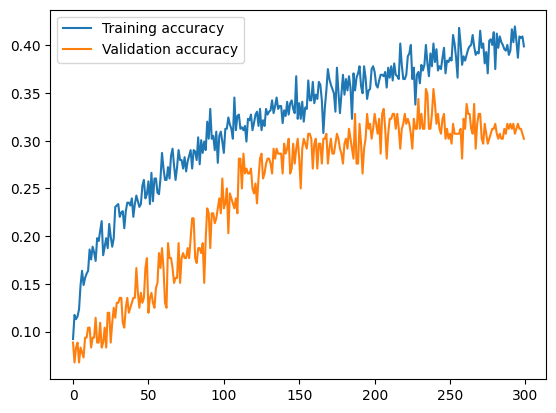

0.3541666666666667


In [78]:
# plot accuracy and loss
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

plt.plot(train_accs, label='Training accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.legend()
plt.show()

print(max(val_accs))